In [142]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import networkx as nx
#from causalgraphicalmodels import CausalGraphicalModel
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
import pandas as pd
import yfinance as yf
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from minepy import MINE

### Information theory and causal inference

Information theory and causal inference play pivotal role in advancing our understanding of complex systems and enabling intelligent decision-making.

**Information theory** provides a framework for quantifying and analyzing the amount of information contained in scientific data, enabling scientists to assess the significance of findings, develop efficient data acquisition strategies, and optimize experimental designs. By applying information theory principles, researchers can uncover patterns, reduce noise, and extract essential features, leading to a deeper understanding of natural processes.

**Causal inference** is crucial for extracting meaningful insights from data and making reliable predictions. Causal inference techniques help us move beyond mere correlations and identify the cause-and-effect mechanisms underlying observed data patterns. By uncovering causal relationships, we can make informed predictions, perform counterfactual analyses, and intervene on systems to achieve desired outcomes. Causal inference plays a particularly significant role in domains such as healthcare, economics, and social sciences, where understanding and manipulating causal factors are very important.

Causal inference, helps unravel cause-and-effect relationships in complex systems. By employing causal inference techniques, we can identify the factors that drive observed phenomena, validate hypotheses, and design experiments to test causal relationships rigorously. 

### Information theory. Mutual Information

The mutual information (MI) is the amount of shared information between X and Y. It is a measure of their statistical dependence. MI can be thought of as a non-linear form of correlation. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors.

#### Download a dataset for calculating the mutual information (financial markets)

In [82]:
# Define the list of symbols
symbols = ['AAPL', '^TNX', '^GSPC', 'EURUSD=X', 'GC=F']

# Define the date range 
start_date = '2023-01-01'
end_date = '2023-06-01'

# Download the historical data
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Rename the columns  
data.columns = ['AAPL', 'US10Y', 'S&P500', 'EURUSD', 'GOLD']

# Create the regression task target
data['target'] = data['AAPL'].shift(-1)

# Shift the dataset
data_shifted = data.shift(1).dropna()

# Separate the target variable
target = data_shifted['target']

# Drop the target variable and AAPL from the features
features = data_shifted.drop(['target', 'AAPL'], axis=1)

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Calculate mutual information between target and features
mi_scores = mutual_info_regression(features_normalized, target)

# Create a DataFrame for mutual information scores
mutual_info = pd.DataFrame(data=mi_scores, index=features.columns, columns=["Score"])

# Sort the DataFrame by score in descending order
mutual_info.sort_values(by='Score', ascending=False, inplace=True)

# Display the top n features
top_features = mutual_info.head(4)
top_features

[*********************100%***********************]  5 of 5 completed


,Score
S&P500,0.976005
US10Y,0.588562
EURUSD,0.529388
GOLD,0.411749


#### Information theory. Jensen-Shannon Divergence. 
It is a symmetric and smoothed version of the Kullback-Leibler (KL) Divergence, which measures the similarity or dissimilarity between two probability distributions.

[*********************100%***********************]  4 of 4 completed


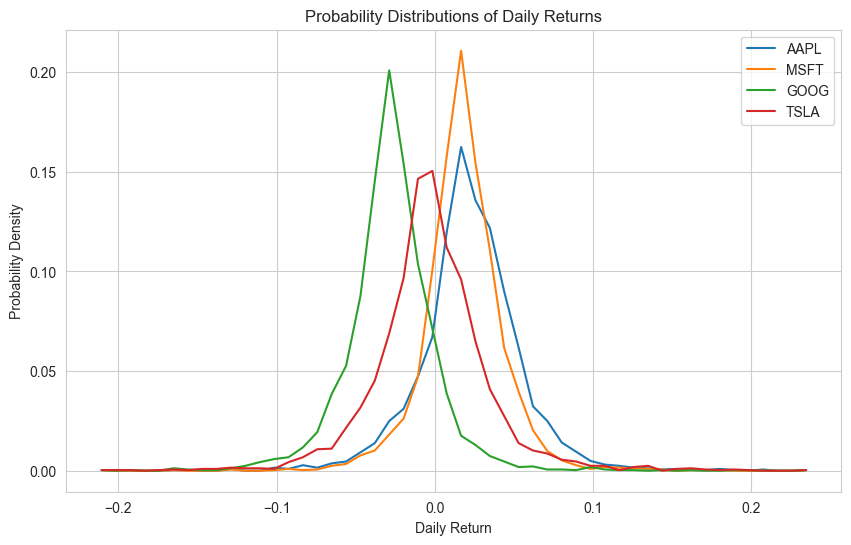

Jensen-Shannon Divergence:
AAPL: 0.0000
MSFT: inf
GOOG: inf
TSLA: inf


In [69]:
# Define the symbols of the stocks
symbols = ['AAPL', 'MSFT', 'GOOG', 'TSLA']

# Define the date range for the data
start_date = '2010-01-01'
end_date = '2023-06-01'

# Download the historical data for the assets
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Calculate the daily returns for the assets
returns = data.pct_change().dropna()

# Set the number of bins for the histograms
num_bins = 50

# Create a dictionary to store the distributions and JSD
distributions = {}
jsd_values = {}

# Calculate the probability distributions and JSD for each asset
for symbol in symbols:
    # Extract the daily return series
    returns_asset = returns[symbol]
    
    # Calculate the probability distribution of daily returns
    dist_asset, bins_asset = np.histogram(returns_asset, bins=num_bins, density=True)
    
    # Calculate the probability distribution normalized by the sum
    dist_asset_norm = dist_asset / np.sum(dist_asset)
    
    # Calculate the average distribution
    average_dist = np.mean(list(distributions.values()), axis=0) if distributions else dist_asset_norm
    
    # Calculate the JSD between the distribution and the average distribution
    jsd = 0.5 * (entropy(dist_asset_norm, average_dist) + entropy(average_dist, dist_asset_norm))
    
    # Store the distribution and JSD
    distributions[symbol] = dist_asset_norm
    jsd_values[symbol] = jsd

# Plot the probability distributions
plt.figure(figsize=(10, 6))
for symbol in symbols:
    plt.plot(bins_asset[:-1], distributions[symbol], label=symbol)
plt.xlabel('Daily Return')
plt.ylabel('Probability Density')
plt.title('Probability Distributions of Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

# Print the JSD values
print("Jensen-Shannon Divergence:")
for symbol in symbols:
    print("{}: {:.4f}".format(symbol, jsd_values[symbol]))


The results are not very informative for the practical application.

### Information theory. Wiener–Granger Causality

Transfer entropy is closely related to Wiener–Granger causality. It is based on the premise that cause precedes effect, and a cause contains information about the effect that is unique, and is in no other variable.

Granger causality is used to determine whether one time series can be used to predict another time series. It is based on the idea that if a variable X "Granger causes" another variable Y, then the past values of X provide information that helps in predicting the future values of Y beyond what can be predicted using the past values of Y alone.

The Granger causality test evaluates whether the lagged values of one time series are useful in predicting another time series. The test compares the prediction accuracy of a model using only the past values of the dependent variable with a model that includes both the past values of the dependent variable and the past values of a potential causal variable.

The Granger causality test follows the null hypothesis that the potential causal variable does not have a significant causal influence on the dependent variable. If the p-value associated with the test is below a chosen significance level (e.g., 0.05), then the null hypothesis is rejected, suggesting the presence of Granger causality. Conversely, if the p-value is above the significance level, the null hypothesis is not rejected, indicating a lack of evidence for Granger causality.

Granger causality does not imply a direct or deterministic causal relationship between variables but rather suggests a predictive relationship based on past behavior. Therefore, caution should be exercised in interpreting Granger causality results and considering other factors and domain knowledge when assessing causality between variables.

Generate synthetic data (supply and demand)

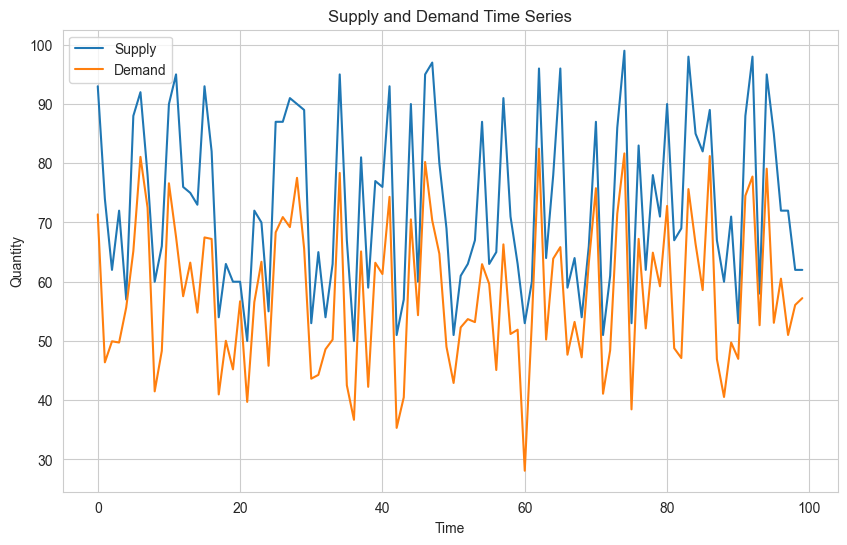

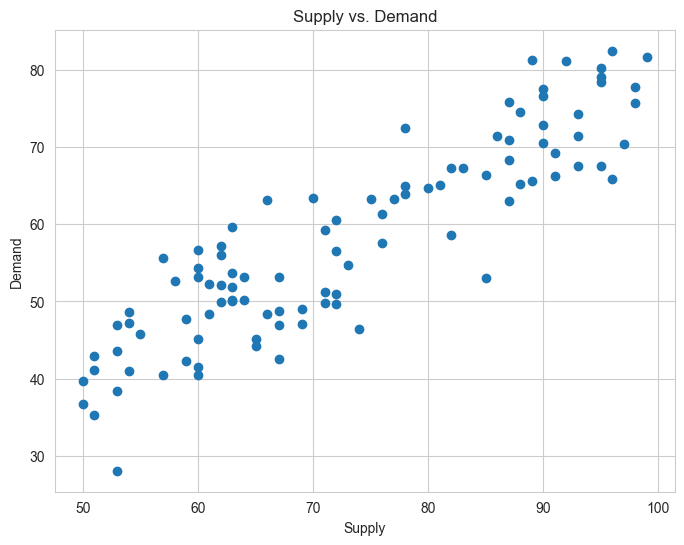


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0640  , p=0.8008  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0660  , p=0.7972  , df=1
likelihood ratio test: chi2=0.0660  , p=0.7973  , df=1
parameter F test:         F=0.0640  , p=0.8008  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2161  , p=0.8061  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=0.4554  , p=0.7963  , df=2
likelihood ratio test: chi2=0.4544  , p=0.7968  , df=2
parameter F test:         F=0.2161  , p=0.8061  , df_denom=93, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1615  , p=0.0148  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=6.3540  , p=0.0117  , df=1
likelihood ratio test: chi2=6.1584  , p=0.0131  , df=1
parameter F test:         F=6.1615  , p=0.0148  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2341  , p=0.0439  , df_d

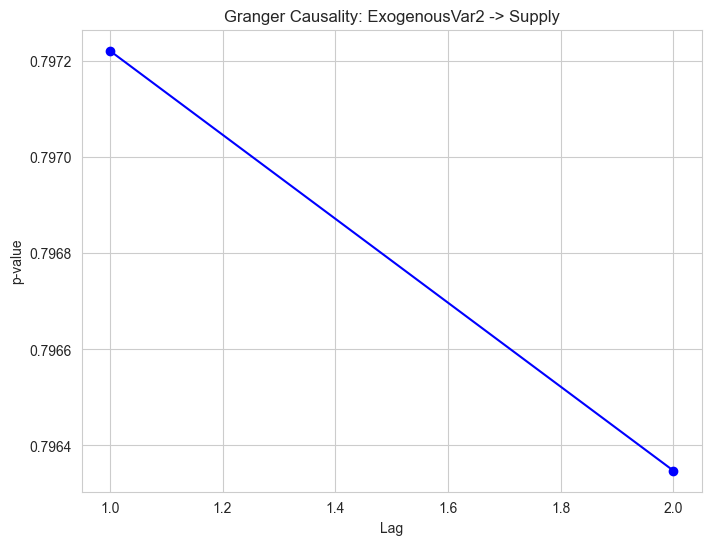

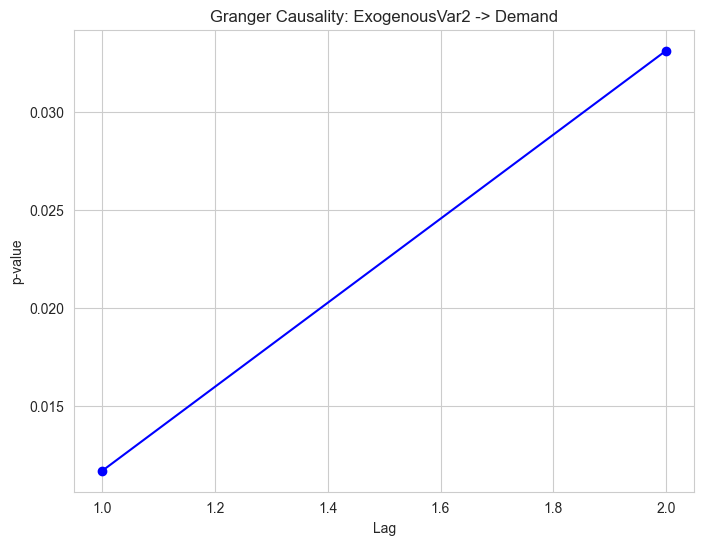

In [108]:
# Define the number of data points
num_points = 100
np.random.seed(14)


# Generate supply and demand data
supply = np.random.randint(50, 100, size=num_points)
demand = np.random.randint(50, 100, size=num_points)

# Increase correlation between supply and demand
demand = 0.8 * supply + np.random.normal(0, 5, size=num_points)

# Generate exogenous variables
exogenous_var1 = np.random.normal(0, 1, size=num_points)
exogenous_var2 = 0.8 * demand + np.random.normal(0, 5, size=num_points)  # Increase correlation with demand
exogenous_var3 = np.random.beta(2, 5, size=num_points)
exogenous_var4 = np.random.lognormal(0, 1, size=num_points)

# Create a DataFrame with the generated data
data = pd.DataFrame({
    'Supply': supply,
    'Demand': demand,
    'ExogenousVar1': exogenous_var1,
    'ExogenousVar2': exogenous_var2,
    'ExogenousVar3': exogenous_var3,
    'ExogenousVar4': exogenous_var4
})

# Calculate correlation between Supply and Demand and visualize time series
correlation = data['Supply'].corr(data['Demand'])

plt.figure(figsize=(10, 6))
plt.plot(data['Supply'], label='Supply')
plt.plot(data['Demand'], label='Demand')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Supply and Demand Time Series')
plt.legend()
plt.show()

# Visualize the relationship between Supply and Demand
plt.figure(figsize=(8, 6))
plt.scatter(data['Supply'], data['Demand'])
plt.xlabel('Supply')
plt.ylabel('Demand')
plt.title('Supply vs. Demand')
plt.show()

# Step 2: Apply Granger causality test to identify factors impacting supply and demand

granger_results_supply = grangercausalitytests(data[['Supply', 'ExogenousVar2']], maxlag=2)
granger_results_demand = grangercausalitytests(data[['Demand', 'ExogenousVar2']], maxlag=2)

# Print the Granger causality results for Supply
print("Granger Causality Test Results for Supply:")
for lag, result in granger_results_supply.items():
    print(f"Lag {lag}: p-value = {result[0]['ssr_chi2test'][1]}")

# Print the Granger causality results for Demand
print("Granger Causality Test Results for Demand:")
for lag, result in granger_results_demand.items():
    print(f"Lag {lag}: p-value = {result[0]['ssr_chi2test'][1]}")

# Visualize Granger causality results for Supply
p_values_supply = [result[0]['ssr_chi2test'][1] for _, result in granger_results_supply.items()]
lags_supply = [lag for lag, _ in granger_results_supply.items()]

plt.figure(figsize=(8, 6))
plt.plot(lags_supply, p_values_supply, marker='o', linestyle='-', color='b')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality: ExogenousVar2 -> Supply')
plt.show()

# Visualize Granger causality results for Demand
p_values_demand = [result[0]['ssr_chi2test'][1] for _, result in granger_results_demand.items()]
lags_demand = [lag for lag, _ in granger_results_demand.items()]

plt.figure(figsize=(8, 6))
plt.plot(lags_demand, p_values_demand, marker='o', linestyle='-', color='b')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality: ExogenousVar2 -> Demand')
plt.show()


### Causal Inference

Generate a synthetic healthcare dataset that mimics real-world healthcare data

In [131]:
np.random.seed(77)
num_samples = 1000 # Define the number of samples

# Generate treated group data
treated_blood_pressure = np.random.normal(110, 5, num_samples)
treated_survival_status = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])  # Lower survival probability
treated_cancer_marker1 = np.random.normal(0.5, 0.1, num_samples)
treated_cancer_marker2 = np.random.normal(3, 0.1, num_samples)
treated_height = np.random.normal(170, 10, num_samples)
treated_weight = np.random.normal(70, 5, num_samples)
treated_age = np.random.normal(50, 10, num_samples)
treated_gender = np.random.choice([0, 1], size=num_samples)  # 0 for Male, 1 for Female
treated_group = ['Treated'] * num_samples

# Generate not treated group data
not_treated_blood_pressure = np.random.normal(120, 8, num_samples)
not_treated_survival_status = np.random.choice([0, 1], size=num_samples, p=[0.4, 0.6])
not_treated_cancer_marker1 = np.random.normal(0.3, 0.1, num_samples)
not_treated_cancer_marker2 = np.random.normal(0.4, 0.1, num_samples)
not_treated_height = np.random.normal(165, 8, num_samples)
not_treated_weight = np.random.normal(65, 5, num_samples)
not_treated_age = np.random.normal(55, 12, num_samples)
not_treated_gender = np.random.choice([0, 1], size=num_samples)  # 0 for Male, 1 for Female
not_treated_group = ['Not Treated'] * num_samples

# Generate survival time for both groups (up to 10 years)
treated_survival_time = np.random.randint(1, 11, num_samples)
not_treated_survival_time = np.random.randint(1, 11, num_samples)

# Combine treated and not treated data
all_blood_pressure = np.concatenate((treated_blood_pressure, not_treated_blood_pressure))
all_survival_status = np.concatenate((treated_survival_status, not_treated_survival_status))
all_cancer_marker1 = np.concatenate((treated_cancer_marker1, not_treated_cancer_marker1))
all_cancer_marker2 = np.concatenate((treated_cancer_marker2, not_treated_cancer_marker2))
all_height = np.concatenate((treated_height, not_treated_height))
all_weight = np.concatenate((treated_weight, not_treated_weight))
all_age = np.concatenate((treated_age, not_treated_age))
all_gender = np.concatenate((treated_gender, not_treated_gender))
all_group = np.concatenate((treated_group, not_treated_group))
all_survival_time = np.concatenate((treated_survival_time, not_treated_survival_time))

# Create a DataFrame with features and target
df = pd.DataFrame({
    'Blood Pressure': all_blood_pressure,
    'Survival Status': all_survival_status,
    'Cancer Marker 1': all_cancer_marker1,
    'Cancer Marker 2': all_cancer_marker2,
    'Height': all_height,
    'Weight': all_weight,
    'Age': all_age,
    'Gender': all_gender,
    'Treatment Group': all_group,
    'Survival Time': all_survival_time
})
df=df.sample(frac=1) # shuffle

df.head(5)


,Blood Pressure,Survival Status,Cancer Marker 1,Cancer Marker 2,Height,Weight,Age,Gender,Treatment Group,Survival Time
1072,114.373080,0,0.154833,0.400625,168.793803,63.580186,56.650208,1,Not Treated,5
1448,130.734375,0,0.439381,0.402845,166.343367,68.194136,38.175561,0,Not Treated,1
1275,113.327824,0,0.406207,0.341166,163.794327,66.849478,71.644492,1,Not Treated,10
641,101.279762,0,0.484449,2.979584,168.311599,77.205775,36.555306,1,Treated,2
1661,119.738394,1,0.178605,0.438978,174.132006,70.592310,51.805217,0,Not Treated,4


In [127]:
df['Survival Status'].value_counts()

0    1173
1     827
Name: Survival Status, dtype: int64

**Average Causal Effect:** The average causal effect refers to the difference in the expected outcomes between a treatment group and a control group. It quantifies the average change in the outcome variable that can be attributed to the treatment. It is commonly used in causal inference to assess the effectiveness or impact of a treatment or intervention.

**Causal Odds Ratio:** The causal odds ratio is a measure used to evaluate the effect of a treatment or exposure on the odds of an outcome occurring. It compares the odds of the outcome in the treated group to the odds of the outcome in the control group. The causal odds ratio provides an estimate of the strength and direction of the association between the treatment and the outcome.

**Causal Relative Risk:** The causal relative risk measures the ratio of the risk of an outcome in the treated group to the risk of the outcome in the control group. It provides an estimate of the relative change in the risk of the outcome due to the treatment. The causal relative risk is commonly used in epidemiology and clinical research to assess the impact of interventions on disease risk.

**Association**: Association refers to the statistical relationship or dependence between two variables. It measures the extent to which changes in one variable are related to changes in another variable. An association does not imply causation, but it suggests that there is a connection or pattern between the variables. Association can be measured using various statistical techniques, such as correlation, contingency tables, regression analysis, or hypothesis testing.

In [128]:
def average_causal_effect(df, treatment_col, outcome_col):
    treated_mean = df.loc[df[treatment_col] == 'Treated', outcome_col].mean()
    not_treated_mean = df.loc[df[treatment_col] == 'Not Treated', outcome_col].mean()
    return treated_mean - not_treated_mean

def causal_odds_ratio(df, treatment_col, outcome_col):
    treated_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].sum()
    treated_non_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].count() - treated_outcomes
    not_treated_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].sum()
    not_treated_non_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].count() - not_treated_outcomes
    return (treated_outcomes / treated_non_outcomes) / (not_treated_outcomes / not_treated_non_outcomes)

def causal_relative_risk(df, treatment_col, outcome_col):
    treated_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].sum()
    treated_non_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].count() - treated_outcomes
    not_treated_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].sum()
    not_treated_non_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].count() - not_treated_outcomes
    return (treated_outcomes / (treated_outcomes + treated_non_outcomes)) / (not_treated_outcomes / (not_treated_outcomes + not_treated_non_outcomes))

def association(df, treatment_col, outcome_col):
    treated_mean = df.loc[df[treatment_col] == 'Treated', outcome_col].mean()
    not_treated_mean = df.loc[df[treatment_col] == 'Not Treated', outcome_col].mean()
    return treated_mean - not_treated_mean

In [123]:
# Calculate the average causal effect
ace = average_causal_effect(df, 'Treatment Group', 'Survival Status')
print('Average Causal Effect:', ace)

# Calculate the causal odds ratio
cor = causal_odds_ratio(df, 'Treatment Group', 'Survival Status')
print('Causal Odds Ratio:', cor)

# Calculate the causal relative risk
crr = causal_relative_risk(df, 'Treatment Group', 'Survival Status')
print('Causal Relative Risk:', crr)

# Calculate the association between two variables
assos = association(df, 'Treatment Group', 'Survival Status')
print("Association (α):", assos)

Average Causal Effect: -0.372
Causal Odds Ratio: 0.19405681899426092
Causal Relative Risk: 0.37055837563451777
Association (α): -0.372


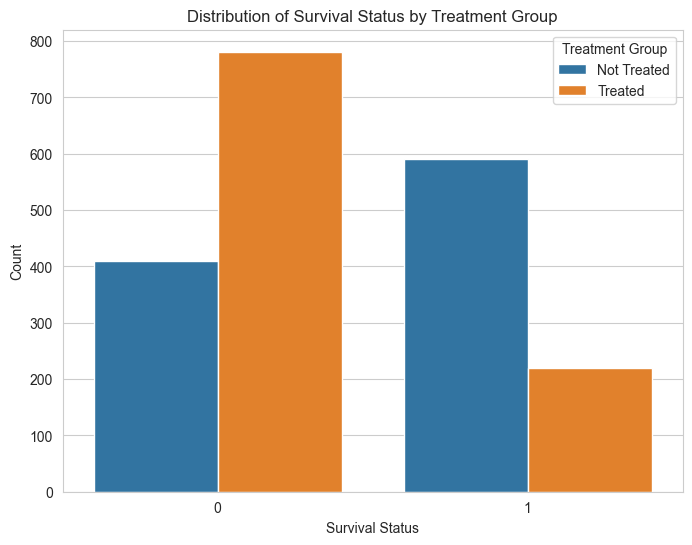

In [118]:
# Create a bar plot of Survival Status by Treatment Group
plt.figure(figsize=(8, 6))
sns.countplot(x='Survival Status', hue='Treatment Group', data=df)
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Distribution of Survival Status by Treatment Group')
plt.legend(title='Treatment Group')
plt.show()

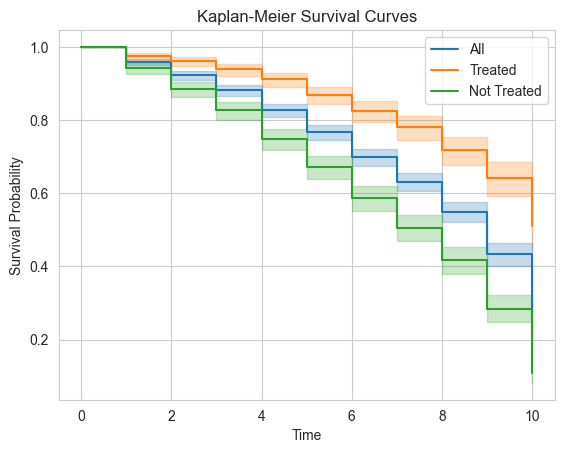

In [119]:
# Fit Kaplan-Meier curves for each treatment group
kmf = KaplanMeierFitter()
kmf.fit(df['Survival Time'], event_observed=df['Survival Status'], label='All')
kmf.plot()

kmf.fit(df.loc[df['Treatment Group'] == 'Treated', 'Survival Time'], event_observed=df.loc[df['Treatment Group'] == 'Treated', 'Survival Status'], label='Treated')
kmf.plot()

kmf.fit(df.loc[df['Treatment Group'] == 'Not Treated', 'Survival Time'], event_observed=df.loc[df['Treatment Group'] == 'Not Treated', 'Survival Status'], label='Not Treated')
kmf.plot()

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves')
plt.legend()
plt.show()

### Causal Inference. Simpson's paradox 
is a statistical phenomenon in which a trend or relationship appears when data is analyzed as a whole but reverses or disappears when the data is divided into subgroups. In other words, the direction or strength of an association can be misleading or contradicted when lurking variables or confounding factors are not properly accounted for.

The paradox arises when the association observed within each subgroup is different from the association observed in the combined or aggregated data. This can lead to misleading conclusions or incorrect interpretations if the underlying factors are not carefully examined.

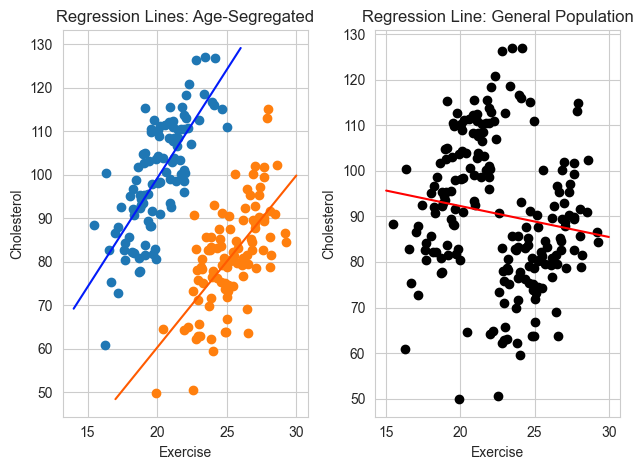

In [123]:
# Generate data for age group 1
x1 = np.random.normal(20, 2, 100)
y1 = [4*x + np.random.normal(20, 10) for x in x1]
m1, b1 = np.polyfit(x1, y1, 1)

# Generate data for age group 2
x2 = np.random.normal(25, 2, 100)
y2 = [4*x + np.random.normal(-20, 10) for x in x2]
m2, b2 = np.polyfit(x2, y2, 1)

# Generate data for the general population
m3, b3 = np.polyfit(np.concatenate((x1, x2)), np.concatenate((y1, y2)), 1)

plt.subplot(1, 2, 1)
plt.scatter(x1, y1)
plt.scatter(x2, y2)
xr1 = np.array([14, 26])
xr2 = np.array([17, 30])
plt.plot(xr1, m1*xr1 + b1, c='#021bf9')
plt.plot(xr2, m2*xr2 + b2, c='#ff5b00')
plt.xlabel('Exercise')
plt.ylabel('Cholesterol')
plt.title('Regression Lines: Age-Segregated')

plt.subplot(1, 2, 2)
plt.scatter(x1, y1, c='black')
plt.scatter(x2, y2, c='black')
x3 = np.array([15, 30])
plt.plot(x3, m3*x3 + b3, c='red')
plt.xlabel('Exercise')
plt.ylabel('Cholesterol')
plt.title('Regression Line: General Population')

plt.tight_layout()
plt.show()


#### Causal inference. Association. Conditinal probability
We will use Structural causal model as our data-generating process for educational purposes

  Treatment Group  Gender  Survival Status
0     Not Treated       0         0.397614
1     Not Treated       1         0.390342
2         Treated       0         0.816733
3         Treated       1         0.803213


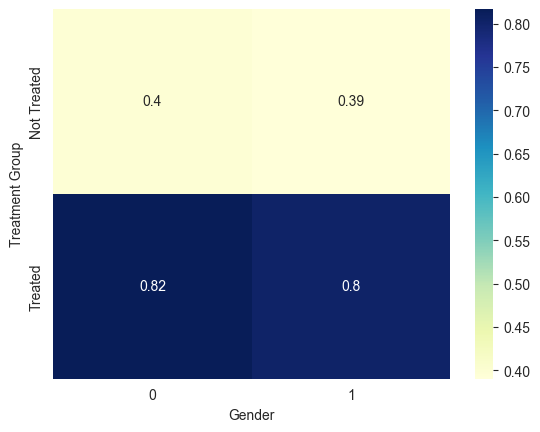

In [139]:
# Conditional probabilities of survival status based on treatment group and gender
conditional_probabilities = df.groupby(['Treatment Group', 'Gender'])['Survival Status'].mean().reset_index()

# Display the conditional probabilities as a table
print(conditional_probabilities);

# Visualize the conditional probabilities using a heatmap
pivot_table = conditional_probabilities.pivot('Treatment Group', 'Gender', 'Survival Status')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', cbar=True);

In [153]:
class GeneralSCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_0 = stats.uniform()
        self.u_1 = stats.norm()
    
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_0 = self.u_0.rvs(sample_size)
        u_1 = self.u_1.rvs(sample_size)
        
        state_0 = u_0 > 0.78
        disease_1 = (state_0 + 0.5 * u_1) > 0.3
        
        return state_0, disease_1
    


In [154]:
scm = GeneralSCM(random_seed=77)
state_0, disease_1 = scm.sample(100)

proba_state_0 = pd.Series(state_0).value_counts(normalize=True)[True]
proba_disease_1 = pd.Series(disease_1).value_counts(normalize=True)[True]

print(f'Probability of being in state 0: {proba_state_0:0.3f}')
print(f'Probability of having disease 1: {proba_disease_1:0.3f}')

# Compute conditional probabilities
proba_state_0_given_disease_1 = pd.Series(state_0[disease_1]).value_counts(normalize=True)[True]
proba_disease_1_given_state_0 = pd.Series(disease_1[state_0]).value_counts(normalize=True)[True]

print(f'Probability of being in state 0 given disease 1: {proba_state_0_given_disease_1:0.3f}')
print(f'Probability of having disease 1 given state 0: {proba_disease_1_given_state_0:0.3f}')

Probability of being in state 0: 0.220
Probability of having disease 1: 0.430
Probability of being in state 0 given disease 1: 0.465
Probability of having disease 1 given state 0: 0.909


Associations are valuable as they enable us to make meaningful predictions with practical implications even when we don't have knowledge about how the data is generated. By examining the conditional probability, we were able to assess the strength of the association between the state and disease. This allowed us to draw conclusions solely based on observational data, without relying on knowledge of the true data-generating process.

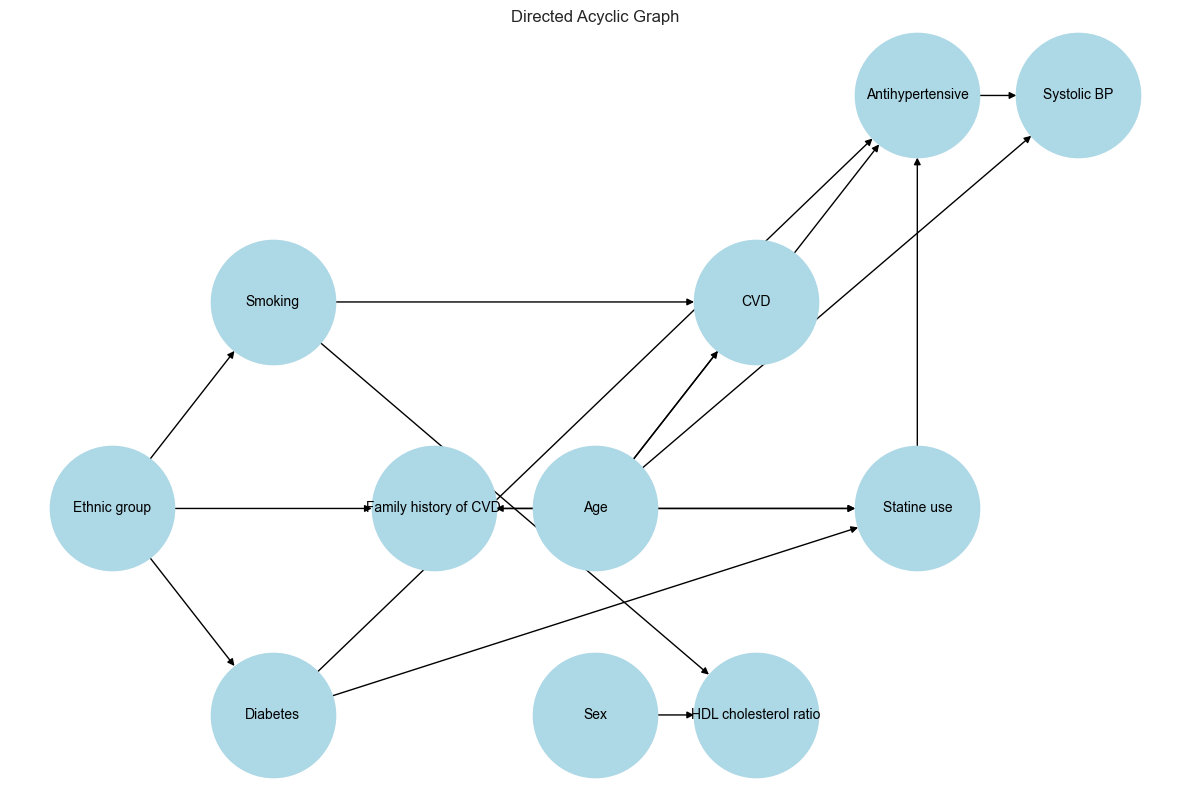

In [169]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed acyclic graph
dag = nx.DiGraph()

# Define the nodes and their positions
nodes = {
    "Ethnic group": (0, 0),
    "Smoking": (1, 1),
    "Diabetes": (1, -1),
    "Family history of CVD": (2, 0),
    "Age": (3, 0),
    "CVD": (4, 1),
    "Statine use": (5, 0),
    "Antihypertensive": (5, 2),
    "Systolic BP": (6, 2),
    "HDL cholesterol ratio": (4, -1),
    "Sex": (3, -1)
}

# Add nodes to the graph
dag.add_nodes_from(nodes.keys())

# Define edges
edges = [
    ("Ethnic group", "Smoking"),
    ("Ethnic group", "Diabetes"),
    ("Ethnic group", "Family history of CVD"),
    ("Age", "CVD"),
    ("Age", "Family history of CVD"),
    ("Age", "Statine use"),
    ("Age", "Antihypertensive"),
    ("Age", "Systolic BP"),
    ("Smoking", "CVD"),
    ("Smoking", "HDL cholesterol ratio"),
    ("Sex", "HDL cholesterol ratio"),
    ("Diabetes", "Statine use"),
    ("Diabetes", "Antihypertensive"),
    ("Family history of CVD", "Statine use"),
    ("Statine use", "Antihypertensive"),
    ("Antihypertensive", "Systolic BP")
]

# Add edges to the graph
dag.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(dag, pos=nodes, fixed=nodes.keys(), seed=42)
nx.draw_networkx(dag, pos, with_labels=True, node_size=8000, node_color='lightblue', arrowsize=10, font_size=10)
plt.title("Directed Acyclic Graph")
plt.axis("off")
plt.tight_layout()
plt.show()


### Causal inference. Intervention


In [179]:
SAMPLE_SIZE = 1000

u_0 = np.random.randn(SAMPLE_SIZE)
u_1 = np.random.randn(SAMPLE_SIZE)
a = u_0
b = 5 * a + u_1
r, p = stats.pearsonr(a, b)
print(f'Mean of B before any intervention: {b.mean():.3f}')
print(f'Variance of B before any intervention: {b.var():.3f}')
print(f'Correlation between A and B:\nr = {r:.3f}; p = {p:.3f}\n')

Mean of B before any intervention: -0.168
Variance of B before any intervention: 25.565
Correlation between A and B:
r = 0.980; p = 0.000



In [182]:
SAMPLE_SIZE = 100

np.random.seed(45)

u_0 = np.random.randn(SAMPLE_SIZE)
u_1 = np.random.randn(SAMPLE_SIZE)
state_0 = u_0
disease_1 = 5 * state_0 + u_1

r, p = stats.pearsonr(state_0, disease_1)

print(f'Mean of disease_1 before any intervention: {disease_1.mean():.3f}')
print(f'Variance of disease_1 before any intervention: {disease_1.var():.3f}')
print(f'Correlation between state_0 and disease_1:\nr = {r:.3f}; p = {p:.3f}\n')

state_0 = np.array([1.5] * SAMPLE_SIZE)
disease_1 = 5 * state_0 + u_1

print(f'Mean of disease_1 after the intervention on state_0: {disease_1.mean():.3f}')
print(f'Variance of disease_1 after the intervention on state_0: {disease_1.var():.3f}\n')

state_0 = u_0
disease_1 = np.random.randn(SAMPLE_SIZE)

r, p = stats.pearsonr(state_0, disease_1)

print(f'Mean of B after the intervention on B: {disease_1.mean():.3f}')
print(f'Variance of B after the intervention on B: {disease_1.var():.3f}')
print(f'Correlation between A and B after intervening on B:\nr = {r:.3f}; p = {p:.3f}\n')

Mean of B before any intervention: -0.620
Variance of B before any intervention: 22.667
Correlation between A and B:
r = 0.978; p = 0.000

Mean of B after the intervention on A: 7.575
Variance of B after the intervention on A: 1.003

Mean of B after the intervention on B: 0.186
Variance of B after the intervention on B: 0.995
Correlation between A and B after intervening on B:
r = -0.023; p = 0.821



After the intervention, it is important to note that the correlation between state_0 and disease_1 dropped significantly close to zero (r = 0), and the corresponding p-value suggests a lack of statistical significance.
This indicates that after the intervention, state_0 and disease_1 became (linearly) independent. This result suggests that there is no causal link from disease_1 to state_0.

However, previous results demonstrated that intervening on state_0 changes disease_1, indicating that there is a causal link from state_0 to disease_1. 

### Causal inference. Non-linear relationships
While there can be a clear causal link between X and Y from a structural perspective, the correlation coefficient may be close to zero. This is because the relationship between X and Y can be non-monotonic, and traditional correlation metrics like Pearson's r or Spearman's rho are unable to capture such relationships. This highlights an important realization that the absence of traditional correlation does not imply independence between variables.

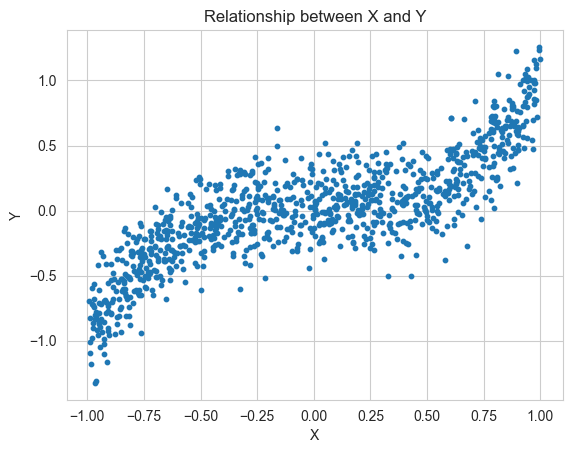

Correlation Coefficients:
Pearson's r: 0.816
Spearman's rho: 0.812
Maximal Information Coefficient (MIC): 0.519


In [185]:
# Generate sample data with non-linear, non-monotonic relationship
np.random.seed(42)
X = np.random.uniform(-1, 1, 1000)
Y = X**3 + np.random.normal(0, 0.2, 1000)

# Calculate correlation coefficients
pearson_corr, _ = stats.pearsonr(X, Y)
spearman_corr, _ = stats.spearmanr(X, Y)

# Calculate the MIC between X and Y
mine = MINE()
mine.compute_score(X, Y)
mic = mine.mic()

# Plot the data points
plt.scatter(X, Y, s=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Relationship between X and Y')
plt.grid(True)
plt.show()

# Print the correlation coefficients and MIC value
print("Correlation Coefficients:")
print(f"Pearson's r: {pearson_corr:.3f}")
print(f"Spearman's rho: {spearman_corr:.3f}")
print(f"Maximal Information Coefficient (MIC): {mic:.3f}")


**The Maximal Information Coefficient (MIC)**:
is an information-theoretic metric that measures the strength of the relationship between two variables. It provides a way to assess the association between variables, particularly in cases where traditional correlation measures may not capture the underlying relationship.

The interpretation of the MIC value is as follows:

A higher MIC value indicates a stronger relationship between the variables.
A MIC value of 1 signifies a perfect relationship, indicating that the variables are completely dependent on each other.
A MIC value close to 0 indicates a weak or no relationship between the variables.
The MIC value is normalized, meaning it falls within the range of 0 to 1, making it comparable across different datasets.

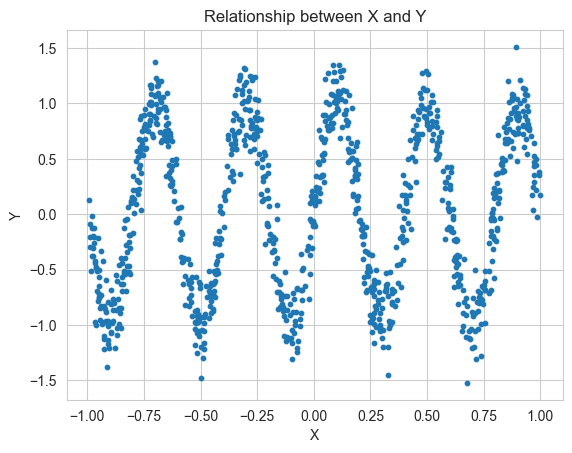

Correlation Coefficients:
Pearson's r: 0.132
Spearman's rho: 0.132
Maximal Information Coefficient (MIC): 0.920


In [186]:
import numpy as np
import matplotlib.pyplot as plt
from minepy import MINE
from scipy import stats

# Generate sample data with low correlation but high MIC
np.random.seed(42)
X = np.random.uniform(-1, 1, 1000)
Y = np.sin(5 * np.pi * X) + np.random.normal(0, 0.2, 1000)

# Calculate correlation coefficients
pearson_corr, _ = stats.pearsonr(X, Y)
spearman_corr, _ = stats.spearmanr(X, Y)

# Calculate the MIC between X and Y
mine = MINE()
mine.compute_score(X, Y)
mic = mine.mic()

# Plot the data points
plt.scatter(X, Y, s=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Relationship between X and Y')
plt.grid(True)
plt.show()

# Print the correlation coefficients and MIC value
print("Correlation Coefficients:")
print(f"Pearson's r: {pearson_corr:.3f}")
print(f"Spearman's rho: {spearman_corr:.3f}")
print(f"Maximal Information Coefficient (MIC): {mic:.3f}")


### Causal inference. Counterfactuals


In [ ]:
# Load the healthcare dataset
data = pd.read_csv("healthcare_dataset.csv")

# Create a causal model
model = dowhy.api.CausalModel(
    data=data,
    treatment='treatment_variable',
    outcome='outcome_variable',
    graph='causal_graph.dot'  # Path to a DOT file specifying the causal graph
)

# Identify causal effect and estimate it using a specific method
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate',
    control_value=0, treatment_value=1
)

# Refute the obtained estimate using a different method
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name='random_common_cause'
)

# Visualize the causal graph
model.view_model()

# Display the causal effect estimate and refutation results
print(estimate)
print(refute_results)